In [21]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from transformers import BertModel, BertTokenizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

# 1. Implementation

### Encode words

In [89]:
def encode_words(model_name_or_path, sentences):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    max_len = 0
    for i in indexed_tokens:
        if len(i) > max_len:
            max_len = len(i)
    print("   Maximum length in dataset: {}".format(max_len))

    print("   Padding/Truncating sentences according to the maximum length...")
    padded = np.array([i + [0]*(max_len-len(i)) for i in indexed_tokens])

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, um the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, sentences, words_of_interest, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    embeddings = []
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if words_of_interest[i] in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            embeddings.append(df.loc[df['Token']==words_of_interest[i], ~df.columns.isin(['Token','Sentence'])].values[0])

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(words_of_interest[i])
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
       
    return np.array(embeddings)

### Cosine similarity visualisation

In [90]:
def compute_cosine_matrix(embeddings):
    """
    Given an array of word embeddings, compute the cosine similarity matrix.
    """
    matrix = np.zeros((len(sentences), len(sentences)))
    for i, sent in enumerate(sentences):
        for j, sent in enumerate(sentences):
            matrix[i,j] = 1 - cosine(embeddings[i], embeddings[j])
    return matrix

### PCA visualisation

In [102]:
def perform_pca(words_of_interest, word_embeddings, relationships, ax, title):
    """
    """
    pca = PCA(n_components=3, random_state = 42)
    pca_result = pca.fit_transform(word_embeddings)

    pca_df = pd.DataFrame()
    pca_df['word'] = words_of_interest
    pca_df['pca-one'] = pca_result[:,0]
    pca_df['pca-two'] = pca_result[:,1] 
    pca_df['pca-three'] = pca_result[:,2]
    print(title + ' - Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

    # Scatterplot.
    ax.scatter(x = pca_df['pca-one'].values, 
               y = pca_df['pca-two'].values)
    ax.set_title(title)
    for line in pca_df.index:
        ax.text(pca_df.loc[line,"pca-one"]+0.2, 
                 pca_df.loc[line,"pca-two"]+0.2, 
                 pca_df.loc[line,"word"], 
                 horizontalalignment='left', 
                 size='medium', 
                 color='gray',
                 weight='semibold')
    
    # Draw arrows between entities in relationships.
    for rel in relationships:
        entity_a = pca_df.loc[pca_df['word']==rel[0], pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
        entity_b = pca_df.loc[pca_df['word']==rel[1], pca_df.columns.isin(['pca-one','pca-two'])].values[0].tolist()
        ax.arrow(entity_a[0], entity_a[1],
                 entity_b[0]-entity_a[0], entity_b[1]-entity_a[1],
                 head_width=1, head_length=1,
                 fc='lightblue', ec='lightblue',
                 length_includes_head=True)
    return

### Run

In [110]:
def run(sentences, words_of_interest, relationships):
    """
    """
    #--------------
    # Encode words
    #--------------
    print("BERT-base")
    bert_df = encode_words('bert-base-cased', sentences)
    print("NetBERT")
    netbert_df = encode_words('../_models/netbert/checkpoint-1027000/', sentences)


    #---------------------
    # Get word embeddings
    #---------------------
    bert_embeddings = get_embeddings(bert_df, sentences, words_of_interest, 'bert-base-cased')
    netbert_embeddings = get_embeddings(netbert_df, sentences, words_of_interest, '../_models/netbert/checkpoint-1027000/')


    #-------------------------
    # Visualize cosine matrix
    #-------------------------
    bert_matrix = compute_cosine_matrix(bert_embeddings)
    netbert_matrix = compute_cosine_matrix(netbert_embeddings)

    bert_cm = pd.DataFrame(bert_matrix, index=words_of_interest, columns=words_of_interest)
    netbert_cm = pd.DataFrame(netbert_matrix, index=words_of_interest, columns=words_of_interest)

    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    sn.heatmap(bert_cm, annot=False, cmap="coolwarm")
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10, horizontalalignment='center', rotation=0) 
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10, rotation=0)
    ax1.set_title("BERT-base")

    ax2 = fig.add_subplot(1, 2, 2)
    sn.heatmap(netbert_cm, annot=False, cmap="coolwarm")
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=10, horizontalalignment='center', rotation=0) 
    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=10, rotation=0)
    ax2.set_title("NetBERT")

    plt.tight_layout()
    plt.show()
    #plt.savefig(outdir+"confusion_matrix.png")


    #---------------
    # Visualize PCA
    #---------------
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))
    perform_pca(words_of_interest, bert_embeddings, relationships, ax1, 'BERT-base')
    perform_pca(words_of_interest, netbert_embeddings, relationships, ax2, 'NetBERT')
    plt.show()
    return
    

# 2. Tests

### 2.1. General domain

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 11
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 11
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


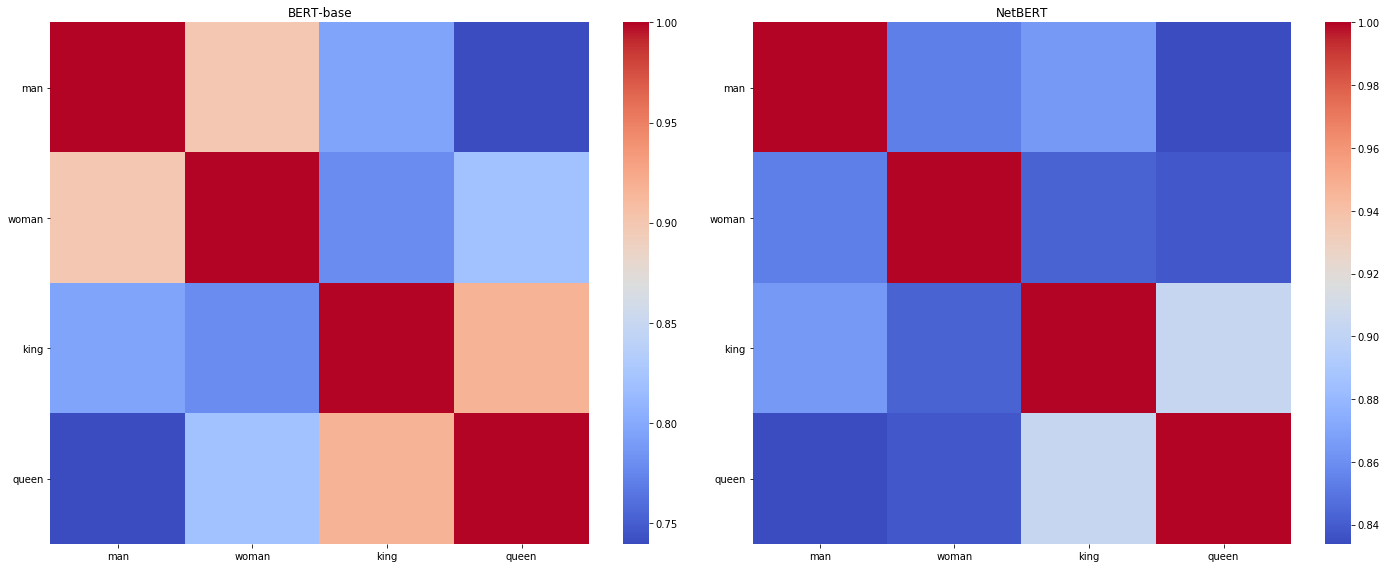

BERT-base - Explained variation per principal component: [0.65541613 0.2652938  0.07929007]
NetBERT - Explained variation per principal component: [0.44062078 0.34890294 0.2104761 ]


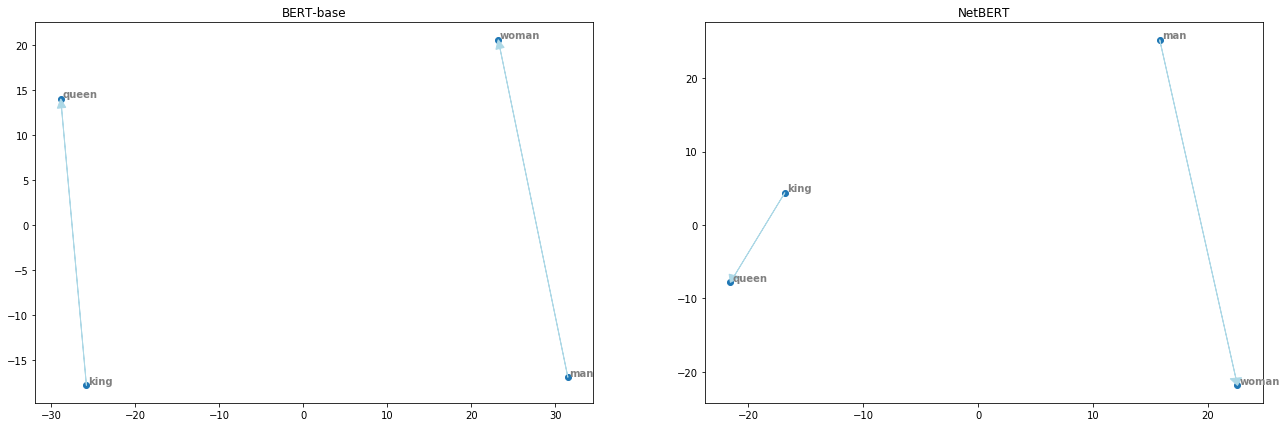

In [111]:
sentences = ["A man is an adult male person",
             "A woman is an adult female person.",
             #"A boy is a male child.",
             #"A girl is a female child.",
             "A king is a male sovereign or monarch.",
             "A queen is a female sovereign or monarch."]
words_of_interest = ['man', 'woman',
                     #'boy', 'girl',
                     'king', 'queen']
relationships = [('man','woman'),('king','queen')]
run(sentences, words_of_interest, relationships)

## 2.2. Computer network domain

BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 24
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Maximum length in dataset: 24
   Padding/Truncating sentences according to the maximum length...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...


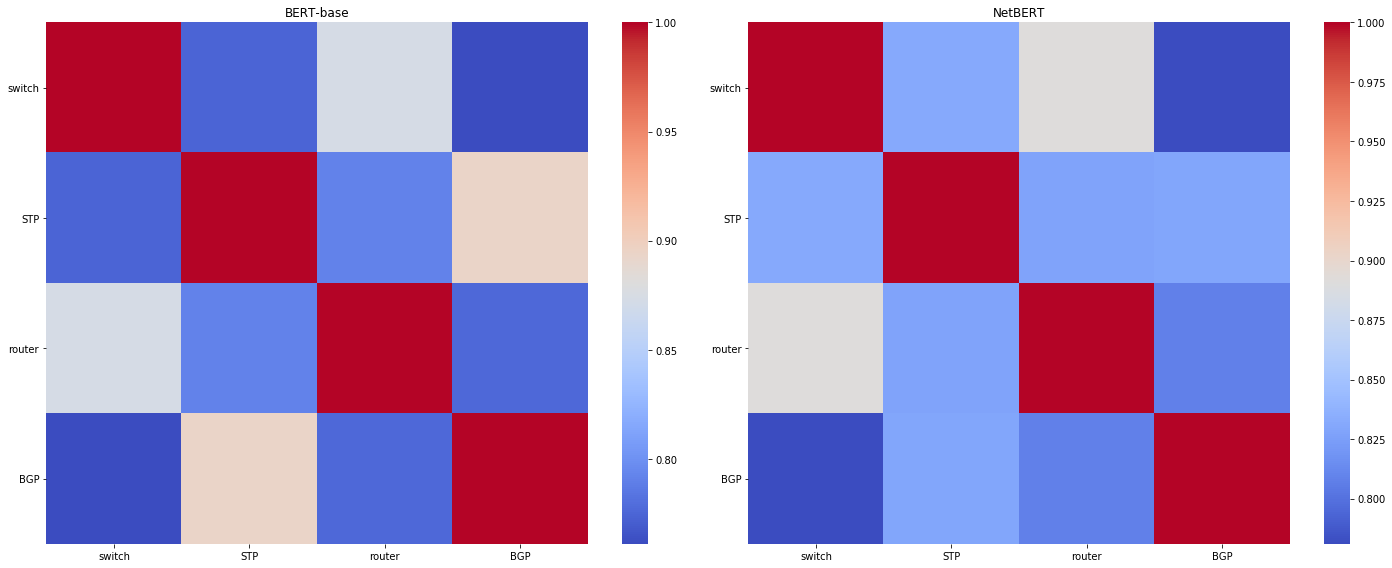

BERT-base - Explained variation per principal component: [0.5914518  0.23155499 0.17699324]
NetBERT - Explained variation per principal component: [0.48219618 0.30489445 0.21290937]


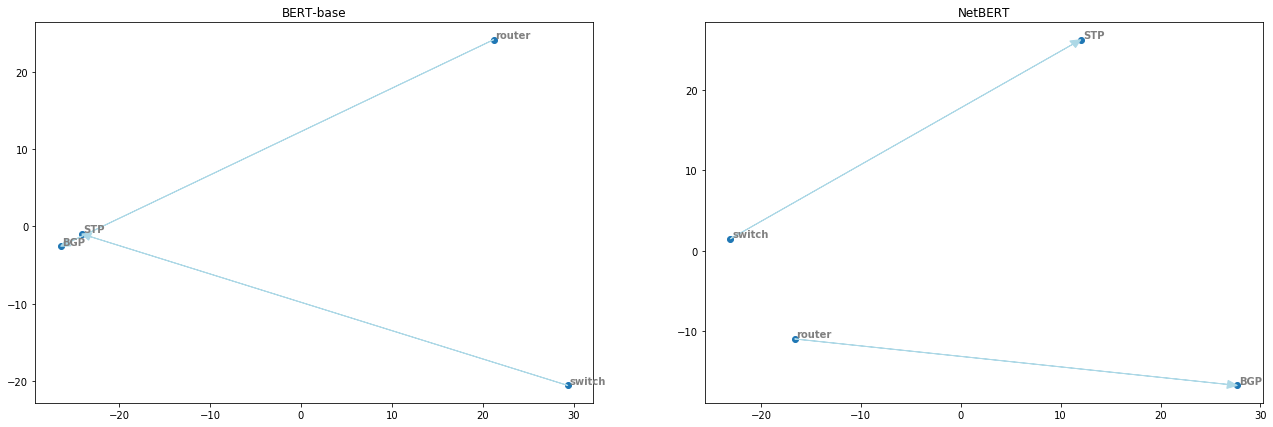

TypeError: run() missing 1 required positional argument: 'relationships'

In [112]:
sentences = ["A switch is a networking hardware that connects devices together to create a computer network.",
             "STP is a network protocol that builds a loop-free logical topology for Ethernet networks.",
             "A router is a networking device that connects multiple switches and their respective networks.",
             "BGP is a standardized routing protocol designed to exchange routing and reachability information among autonomous systems on the Internet."]
words_of_interest = ['switch', 'STP', 'router', 'BGP']
relationships = [('switch', 'STP'),('router', 'BGP')]
run(sentences, words_of_interest, relationships)

In [ ]:
# List Mark
DNS
mDNS

LAN
WAN
CAN
MAN

ACL
PACL
VACL

HSRP
VRRP
GLBP

EIGRP
IGRP
BGP
EBGP

STP
DTP
VTP